# Imports

In [1]:
#load txt files as csv into numpy arrays
import numpy as np
import kaleido #required
kaleido.__version__ #0.2.1

import plotly
plotly.__version__ #5.5.0

#now this works:
import plotly.graph_objects as go
from scipy.signal import find_peaks
import os
from os.path import isfile, join
import pandas as pd

# Helper functions

In [4]:
def load_data(file_path):
    array = np.loadtxt(file_path, delimiter='\t', skiprows=1)
    #Remove first column (index)
    array = array[:,1:]
    return array


def compute_firing_frequency(peaks, num_samples, sampling_rate):
    """
    Compute the firing frequency (peaks per second) based on identified peaks.
    
    Parameters:
    - peaks: array-like, indices of the detected peaks.
    - num_samples: int, total number of samples in the recording.
    - sampling_rate: int, number of samples per second (e.g., 100).
    
    Returns:
    - firing_frequency: list, firing frequency (peaks per second) for each second.
    """
    # Calculate the total recording time in seconds
    total_seconds = num_samples // sampling_rate
    
    # Initialize a list to hold the firing frequency for each second
    firing_frequency = []
    
    # Loop through each second and count the number of peaks in that interval
    for sec in range(total_seconds):
        start_idx = sec * sampling_rate  # Start of the second in samples
        end_idx = (sec + 1) * sampling_rate  # End of the second in samples
        peaks_in_second = len([peak for peak in peaks if peak >= start_idx and peak < end_idx])
        
        firing_frequency.append(peaks_in_second)
    
    return firing_frequency


# Define rolling window smoothing function
def rolling_window_smooth(signal, window_size):
    """Apply rolling window smoothing using a simple moving average."""
    window = np.ones(window_size) / window_size  # Create a uniform window
    smoothed_signal = np.convolve(signal, window, mode='same')  # Apply smoothing
    return smoothed_signal


def peak_finder(trace):
    window_size = 15  # To be adjusted if needed
    smoothed_trace = rolling_window_smooth(trace, window_size)

    median_val = np.median(smoothed_trace)
    mad = np.median(np.abs(smoothed_trace - median_val)) * 1.4826
    height_threshold = median_val + 3 * mad
    prominence_threshold = 6 * mad
    width_threshold = 10 #Empirically determined
    smoothed_peaks, _ = find_peaks(smoothed_trace, height=height_threshold, prominence=prominence_threshold, width=width_threshold)
    
    heights = []
    peaks = []
    for peak in smoothed_peaks:
        #smoothed peak location might not the actual peak due to smoothing
        #Get the position within original trace corresponding to the largest value in the window
        true_peak = np.argmax(trace[peak-15:peak+15]) + peak - 15
        peaks.append(true_peak)
        absolute_height = trace[true_peak]
        real_height = absolute_height - median_val
        heights.append([absolute_height, real_height])
    return peaks, np.array(heights)


def plot_peaks(roi, trace, peaks, peak_heights, data_output_dir):
    x_arr = np.arange(trace.shape[0]) / 100
    fig = go.Figure()
    #Set figure size
    fig.update_layout(width=1000, height=600)
    fig.add_trace(go.Scatter(x=x_arr, y=trace, name=roi))
    fig.add_trace(go.Scatter(x=[p/100 for p in peaks], y=trace[peaks], mode='markers', name='Peaks'))

    #Now do the same for dark background
    fig.update_layout(template='plotly_dark')
    fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    

    #Add peak heights (from properties) next to the peaks
    # for i, peak in enumerate(peaks):
    #     fig.add_annotation(x=peak, y=trace[peak], text=f'{peak_heights[i]:.2f}', showarrow=False)
    
    output_file_root = os.path.join(data_output_dir, roi + '_peaks')
    #Save the plot as html
    fig.write_html(output_file_root + '.html') 
    #Save the plot as pdf
    fig.write_image(output_file_root + '.pdf', format='pdf')


# Plot the firing frequency
def plot_firing_frequency(firing_freq_per_sec):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(len(firing_freq_per_sec)), y=firing_freq_per_sec))
    fig.update_layout(title='Firing Frequency per Second', xaxis_title='Second', yaxis_title='Firing Frequency')
    fig.show()


#plot noise level for each roi
def plot_noise_level(array):
    #iterating over each roi, calculate the noise level, assuming baseline is at the 5th percentile
    noise_levels = []
    for roi in range(array.shape[1]):
        trace = array[:, roi]
        window_size = 15  # To be adjusted if needed
        smoothed_trace = rolling_window_smooth(trace, window_size)
        median_val = np.median(smoothed_trace)
        mad = np.median(np.abs(smoothed_trace - median_val)) * 1.4826
        noise_levels.append(mad)
    #plot a line of best fit
    line = np.polyfit(np.arange(len(noise_levels)), noise_levels, 1)
    line_fn = np.poly1d(line)   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(len(noise_levels)), y=noise_levels, mode='markers', name='ROIs'))
    fig.add_trace(go.Scatter(x=np.arange(len(noise_levels)), y=line_fn(np.arange(len(noise_levels))), name='Line of Best Fit'))

    #Make the plot black
    fig.update_layout(template='plotly_dark')
    fig.update_layout(xaxis_title='ROI', yaxis_title='Median Absolute Deviation', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    fig.show()


def raw_signal_pearson(array):
    # Compute the Pearson correlation coefficient between each pair of ROIs
    corr_matrix = np.corrcoef(array, rowvar=False)
    # Plot correlation matrix using plotly
    fig = go.Figure(data=go.Heatmap(z=corr_matrix, colorscale='Viridis'))
    fig.update_layout(width=800, height=800)
    #make the plot dark
    fig.update_layout(template='plotly_dark')
    fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    #Add label to heat bar
    fig.update_layout(coloraxis_colorbar=dict(title='Pearson Correlation'))
    #Add labels to x and y axis
    fig.update_xaxes(title_text='ROI ID')
    fig.update_yaxes(title_text='ROI ID')
    fig.show()


def peak_event_cross_correlation(peaks, max_lag=15):
    """
    Calculate the cross-correlation for each pair of ROIs based on actual peak events only.

    Parameters:
    - peaks: numpy array of shape (N, T), where N is the number of ROIs and T is the number of timepoints.
             Values should be 0 (no peak) or 1 (peak).
    - max_lag: int, maximum lag in timepoints for assessing synchrony.

    Returns:
    - event_corrs: numpy array of shape (N, N, 2 * max_lag + 1) with cross-correlation based on peak events only.
    - lags: array of lags used in the cross-correlation.
    """
    N, T = peaks.shape
    lags = np.arange(-max_lag, max_lag + 1)
    event_corrs = np.zeros((N, N, 2 * max_lag + 1))
    
    for i in range(N):
        for j in range(N):
            for lag_index, lag in enumerate(lags):
                shifted_peaks_j = np.roll(peaks[j], lag)
                overlap_indices = np.where(peaks[i] * shifted_peaks_j == 1)[0]
                # Calculate coincidence rate
                if len(overlap_indices) > 0:
                    event_corrs[i, j, lag_index] = len(overlap_indices) / min(np.sum(peaks[i]), np.sum(peaks[j]))
                else:
                    event_corrs[i, j, lag_index] = 0

    return event_corrs, lags


def aggregate_event_cross_correlation(peaks, max_lag=15, aggregation='mean'):
    """
    Calculate and aggregate the event-based cross-correlation for all pairs of ROIs.

    Parameters:
    - peaks: numpy array of shape (N, T), where N is the number of ROIs and T is the number of timepoints.
             Values should be 0 (no peak) or 1 (peak).
    - max_lag: int, maximum lag for assessing synchrony.
    - aggregation: str, either 'mean' or 'max', specifying how to aggregate the correlations across lags.

    Returns:
    - aggregated_corr: numpy array of shape (N, N), representing the aggregated synchrony measure for each ROI pair.
    """
    # Calculate the event-based cross-correlation with the function from the previous step
    event_corrs, lags = peak_event_cross_correlation(peaks, max_lag=max_lag)

    # Aggregate the cross-correlation across lags
    if aggregation == 'mean':
        aggregated_corr = np.mean(event_corrs, axis=2)
    elif aggregation == 'max':
        aggregated_corr = np.max(event_corrs, axis=2)
    else:
        raise ValueError("Aggregation method must be either 'mean' or 'max'")
    
    return aggregated_corr


def full_pipeline(experiment_filename):
    array = load_data(experiment_filename)

    df = pd.read_csv(experiment_filename, delimiter='\t')
    roi_ids = list(df.columns[1:])

    #get the base filename withou txt extension
    experiment_id = os.path.splitext(os.path.basename(experiment_filename))[0]
    data_output_dir = join('data', experiment_id)

    #create output directory if it does not exist
    if not os.path.exists(data_output_dir):
        os.makedirs(data_output_dir)

    experiment_df_columns = ['roi_id', 'peak_time', 'peak_absolute_amplitude', 'peak_relative_amplitude']
    experiment_df = pd.DataFrame(columns=experiment_df_columns)

    for roi, roi_id in enumerate(roi_ids):
        trace = array[:, roi] #selece just one roi 
        peaks, peak_heights = peak_finder(trace)
        
        #Add peaks to experiment_df
        roi_df = pd.DataFrame(columns=experiment_df_columns)
        roi_df['roi_id'] = [roi_id for _ in range(len(peaks))]
        roi_df['peak_time'] = peaks
        roi_df['peak_absolute_amplitude'] = peak_heights[:, 0]
        roi_df['peak_relative_amplitude'] = peak_heights[:, 1]

        experiment_df = pd.concat([experiment_df, roi_df], ignore_index=True)
        plot_peaks(roi_id, trace, peaks, peak_heights[:, 0], data_output_dir)


    #Save experiment_df as csv
    experiment_df.to_csv(os.path.join(data_output_dir, experiment_id + '_experiment_df.csv'), index=False)

    #calculate the average peak-to-peak distance for each ROI (each time sample is 1ms)
    peak_to_peak_dists_columnames = ['roi_id', 'mean_peak_to_peak_distance[ms]', 'mean_firing_frequency[Hz]']
    peak_to_peak_dists = pd.DataFrame(columns=peak_to_peak_dists_columnames)
    recordings_duration = len(array) / 1000 #in seconds
    for roi in experiment_df['roi_id'].unique():
        roi_df = experiment_df[experiment_df['roi_id'] == roi]
        peak_times = roi_df['peak_time'].values
        peak_to_peak_distances = np.diff(peak_times)
        avg_peak_to_peak_distance = np.mean(peak_to_peak_distances)
        mean_firing_frequency = np.array(len(peak_times) / recordings_duration)
        row_df = pd.DataFrame([[roi, avg_peak_to_peak_distance, mean_firing_frequency]], columns=peak_to_peak_dists_columnames)
        peak_to_peak_dists = pd.concat([peak_to_peak_dists, row_df], ignore_index=True)

    #Save peak_to_peak_dists as csv
    peak_to_peak_dists.to_csv(os.path.join(data_output_dir, experiment_id + '_firing_frequency.csv'), index=False)

    # N: number of neurons, T: number of time points
    N = array.shape[1]
    T = array.shape[0]

    #Make a matrix with 1s where peaks are and 0 where they are not
    PeakRegions = np.zeros((N, T))
    for _, row in experiment_df.iterrows():
        roi_id = int(row['roi_id'].rsplit('ROI')[1]) - 1
        PeakRegions[roi_id, int(row['peak_time'])] = 1
    event_corrs, lags = peak_event_cross_correlation(PeakRegions)

    aggregated_corr = aggregate_event_cross_correlation(PeakRegions, max_lag=15, aggregation='mean')

    #Identify what value is on the diagonal and scale the matrix to be between 1 and 0 where the largest value is 1
    diag_value = aggregated_corr[0, 0]
    aggregated_corr = aggregated_corr / diag_value

    #Save the aggregated_corr as csv
    aggregated_corr_df = pd.DataFrame(aggregated_corr)
    aggregated_corr_df.to_csv(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.csv'), index=False)

    # Use plotly to plot the heatmap
    fig = go.Figure(data=go.Heatmap(z=aggregated_corr, colorscale='Inferno'))
    fig.update_layout(width=800, height=800)
    #make the plot dark
    fig.update_layout(template='plotly_dark')
    fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    #Add axis labels
    fig.update_layout(xaxis_title='ROI ID')
    fig.update_layout(yaxis_title='ROI ID')
    
    #save as html and as pdf
    fig.write_html(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.html'))
    fig.write_image(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.pdf'), format='pdf')

# Process data for peak calling

In [3]:
experiment_filename = 'data/Batch124_ApoE2_FOV1.DFF.txt'
array = load_data(experiment_filename)

df = pd.read_csv(experiment_filename, delimiter='\t')
roi_ids = list(df.columns[1:])

#get the base filename withou txt extension
experiment_id = os.path.splitext(os.path.basename(experiment_filename))[0]
data_output_dir = join('data', experiment_id)

#create output directory if it does not exist
if not os.path.exists(data_output_dir):
    os.makedirs(data_output_dir)

experiment_df_columns = ['roi_id', 'peak_time', 'peak_absolute_amplitude', 'peak_relative_amplitude']
experiment_df = pd.DataFrame(columns=experiment_df_columns)

for roi, roi_id in enumerate(roi_ids):
    trace = array[:, roi] #selece just one roi 
    peaks, peak_heights = peak_finder(trace)
    
    #Add peaks to experiment_df
    roi_df = pd.DataFrame(columns=experiment_df_columns)
    roi_df['roi_id'] = [roi_id for _ in range(len(peaks))]
    roi_df['peak_time'] = peaks
    roi_df['peak_absolute_amplitude'] = peak_heights[:, 0]
    roi_df['peak_relative_amplitude'] = peak_heights[:, 1]

    experiment_df = pd.concat([experiment_df, roi_df], ignore_index=True)
    plot_peaks(roi_id, trace, peaks, peak_heights[:, 0], data_output_dir)


#Save experiment_df as csv
experiment_df.to_csv(os.path.join(data_output_dir, experiment_id + '_experiment_df.csv'), index=False)

    # Compute the firing frequency
    # sampling_rate = 100  # 100 samples per second
    # num_samples = len(trace)  # Total number of samples in the trace
    # firing_freq_per_sec = compute_firing_frequency(peaks, num_samples, sampling_rate)
    # plot_firing_frequency(firing_freq_per_sec)
    # firing_freq = np.mean(firing_freq_per_sec)

# Look at peak height distribution

In [20]:
#Plot a histogram of the peak heights
fig = go.Figure()
fig.add_trace(go.Histogram(x=experiment_df['peak_relative_amplitude'], nbinsx=50))
fig.update_layout(title='Peak Heights Histogram', xaxis_title='Peak Height [dF/F]', yaxis_title='Count')
fig.write_html(os.path.join(data_output_dir, 'peak_heights_histogram.html'))
fig.write_image(os.path.join(data_output_dir, 'peak_heights_histogram.pdf'), format='pdf')
fig.show()

# Calculate peak-to-peak distance

In [28]:
#calculate the average peak-to-peak distance for each ROI (each time sample is 1ms)
peak_to_peak_dists_columnames = ['roi_id', 'mean_peak_to_peak_distance[ms]', 'mean_firing_frequency[Hz]']
peak_to_peak_dists = pd.DataFrame(columns=peak_to_peak_dists_columnames)
recordings_duration = len(array) / 1000 #in seconds
for roi in experiment_df['roi_id'].unique():
    roi_df = experiment_df[experiment_df['roi_id'] == roi]
    peak_times = roi_df['peak_time'].values
    peak_to_peak_distances = np.diff(peak_times)
    avg_peak_to_peak_distance = np.mean(peak_to_peak_distances)
    mean_firing_frequency = np.array(len(peak_times) / recordings_duration)
    row_df = pd.DataFrame([[roi, avg_peak_to_peak_distance, mean_firing_frequency]], columns=peak_to_peak_dists_columnames)
    peak_to_peak_dists = pd.concat([peak_to_peak_dists, row_df], ignore_index=True)

#Save peak_to_peak_dists as csv
peak_to_peak_dists.to_csv(os.path.join(data_output_dir, experiment_id + '_firing_frequency.csv'), index=False)


# Synchrony calculation

## Naive synchrony from raw signal

In [10]:
raw_signal_pearson(array)

## Highlight increase in noise with ROI id increase

In [111]:
#Plot traces 0 and 78
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 78], name='ROI 78'))
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 0], name='ROI 0'))
# fig.update_layout(title='Raw Signal Traces', xaxis_title='Time', yaxis_title='Intensity')
# fig.show()

#Now plot the same thing but so that it can be pasted onto black background
fig = go.Figure()
#Create an array for the x axis corresponding to np.arange(array.shape[0]), but in units of seconds rather than ms
x_arr = np.arange(array.shape[0]) / 100
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 78], name='ROI 79'))
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 0], name='ROI 1'))
fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()
#Also export as html, pdf, and png
output_file_root = os.path.join(data_output_dir, 'sample_trace_plot')
fig.write_html(output_file_root + '.html')
fig.write_image(output_file_root + '.pdf', format='pdf')
fig.write_image(output_file_root + '.png', format='png')

In [4]:
plot_noise_level(array)

## Peak coincidence rate

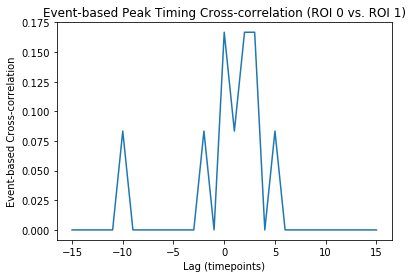

In [12]:
import matplotlib.pyplot as plt

# N: number of neurons, T: number of time points
N = array.shape[1]
T = array.shape[0]

#Make a matrix with 1s where peaks are and 0 where they are not
PeakRegions = np.zeros((N, T))
for _, row in experiment_df.iterrows():
    roi_id = int(row['roi_id'].rsplit('ROI')[1]) - 1
    PeakRegions[roi_id, int(row['peak_time'])] = 1
event_corrs, lags = peak_event_cross_correlation(PeakRegions)

# Plot cross-correlation for a specific pair (e.g., between ROI 0 and ROI 1)
roi1, roi2 = 0, 1
plt.plot(lags, event_corrs[roi1, roi2, :])
plt.xlabel("Lag (timepoints)")
plt.ylabel("Event-based Cross-correlation")
plt.title(f"Event-based Peak Timing Cross-correlation (ROI {roi1} vs. ROI {roi2})")
plt.show()

In [14]:
import seaborn as sns

# Example usage
# Assuming 'data' is your N x T array of peak (0 and 1) data
# data = np.array(...)  # Replace with your actual data

aggregated_corr = aggregate_event_cross_correlation(PeakRegions, max_lag=15, aggregation='mean')

#Identify what value is on the diagonal and scale the matrix to be between 1 and 0 where the largest value is 1
diag_value = aggregated_corr[0, 0]
aggregated_corr = aggregated_corr / diag_value

#Save the aggregated_corr as csv
aggregated_corr_df = pd.DataFrame(aggregated_corr)
aggregated_corr_df.to_csv(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.csv'), index=False)

# Use plotly to plot the heatmap
fig = go.Figure(data=go.Heatmap(z=aggregated_corr, colorscale='Inferno'))
fig.update_layout(width=800, height=800)
#make the plot dark
fig.update_layout(template='plotly_dark')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
#Add axis labels
fig.update_layout(xaxis_title='ROI ID')
fig.update_layout(yaxis_title='ROI ID')
fig.show()

0.03225806451612903


## Synchrony calculation based on PeakCaller

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm

def autocorrelation_synchronization(array, experiment_df):
    """
    Compute a synchronization index based on identified peaks.
    """
    #Using the experiment_df, construct N by T numpy array where N is the roi count and T is the timepoint, where peaks are marked as 1 and 0 otherwise

     # N: number of neurons, T: number of time points
    N = array.shape[1]
    T = array.shape[0]

    #Make a matrix with 1s where peaks are and -1 where they are not
    print('Making peak regions matrix')
    PeakRegions = np.ones((N, T))
    PeakRegions = PeakRegions * -1
    for _, row in experiment_df.iterrows():
        roi_id = int(row['roi_id'].rsplit('ROI')[1]) - 1
        peak_height = row['peak_relative_amplitude']
        PeakRegions[roi_id, int(row['peak_time'])] = 1
        #Add all points to the right of the peak that are above 50% of the peak height
        for i in range(int(row['peak_time']), T):
            if array[i, roi_id] > peak_height * 0.5 + 1:
                PeakRegions[roi_id, i] = 1
            else:
                break
        #Add all points to the left of the peak that are above 50% of the peak height
        for i in range(int(row['peak_time']), 0, -1):
            if array[i, roi_id] > peak_height * 0.5 + 1:
                PeakRegions[roi_id, i] = 1
            else:
                break

    # Build a generalized autocorrelation function (P)
    P = np.zeros((N, T-1))
    for ii in tqdm(range(N), desc="Building Generalized Autocorrelation Function"):
        R = np.outer(PeakRegions[ii, :], PeakRegions[ii, :])
        for jj in range(T-1):
            P[ii, jj] = np.mean(np.diag(R, k=jj))  # autocorrelation at lag jj

    # Initialize synchronization matrix (SI)
    SI = np.zeros((N, N))
    
    # Compute pairwise correlation of the autocorrelation functions (synchronization matrix)
    print('Computing synchronization indices')
    for ii in tqdm(range(N), desc="Computing Synchronization Indices"):
        for jj in range(ii + 1):
            # Pearson correlation coefficient between autocorrelations
            if np.std(P[ii, :]) > 0 and np.std(P[jj, :]) > 0:
                correlation, _ = pearsonr(P[ii, :], P[jj, :])
                SI[ii, jj] = correlation
                SI[jj, ii] = correlation

    # Set NaNs (due to zero standard deviation) to 0
    SI = np.nan_to_num(SI)

    # Mean synchronization index (excluding diagonal terms)
    SImean = np.sum(SI) - np.sum(np.diag(SI))
    SImean /= N * (N - 1)
    return SI, SImean


SI, SImean = autocorrelation_synchronization(array, experiment_df)

 # Plot synchronization matrix using plotly
fig = go.Figure(data=go.Heatmap(z=SI, colorscale='cividis'))
fig.update_layout(title=f'Mean Synchronization Index: {SImean:.3f}', xaxis_title='ROI', yaxis_title='ROI')
#Make sure the figure is square
fig.update_layout(width=800, height=800)
#make the plot dark
fig.update_layout(template='plotly_dark')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
#Add axis labels
fig.update_layout(xaxis_title='ROI ID')
fig.update_layout(yaxis_title='ROI ID')
fig.show()

Making peak regions matrix


Computing Synchronization Indices:   3%|▎         | 2/79 [00:00<00:03, 19.90it/s]

Computing synchronization indices


Computing Synchronization Indices: 100%|██████████| 79/79 [00:01<00:00, 39.75it/s]


# Full pipeline

In [5]:
full_pipeline('data/Batch124_ApoE2_FOV1.DFF.txt')

In [9]:
data_dir = 'data'
# Get all files in the data directory
data_files = [f for f in os.listdir(data_dir) if isfile(join(data_dir, f))]
for f in data_files:
    print(f)
    if f.endswith('.txt'):
        full_pipeline(join(data_dir, f))

Control3.DFF 1.txt
.DS_Store
Control2.DFF 1.txt
